In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import root_mean_squared_error as rmse
import time
import tkinter as tk
from tkinter import messagebox
import math
import matplotlib as mpl
from scipy.spatial import ConvexHull
import glob
# our functions
import predict_Beta_I
import choice_start_day
import plot_hyb

import warnings
warnings.filterwarnings(action='ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

from random import random
# to account for updates when files change
%load_ext autoreload
%autoreload 2

In [3]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set=='train']['file'].values
seeds_val_n = df_seeds_n[df_seeds_n.set=='val']['file'].values

In [6]:
qq = []
for i in seeds_train_n:
    seed_df = pd.read_csv(seed_dir+i.split('\\')[-1])
    q = seed_df[(seed_df['E'] > 0)|(seed_df['I'] > 0)].index[-1]
    qq.append(q)

In [10]:
np.max(qq)

np.int64(249)

In [11]:
seed_dir='initial_data/new_ba_100000/'
fin_df = pd.DataFrame()

for i in seeds_train_n[:5]:
    # Ровно 250 дней
    seed_df = pd.read_csv(seed_dir+i.split('\\')[-1])
    #seed_df = seed_df[(seed_df['E'] > 0)|(seed_df['I'] > 0)]
    
    seed_df['Beta'] = np.log(seed_df['Beta'] + 1e-7) 
    fin_df = pd.concat([fin_df, seed_df['Beta']])


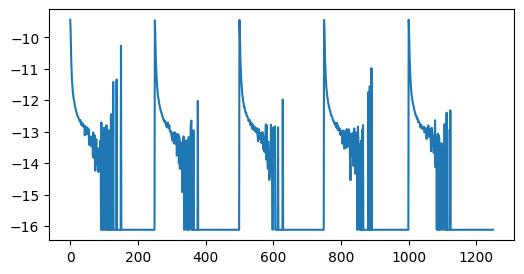

In [17]:
plt.subplots(figsize=(6,3))
plt.plot(fin_df.values)

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(9,5))
axes = ax.flatten()

plot_acf(np.log(train_df.Beta).diff(80).dropna(), ax=axes[0], lags=30)
plot_pacf(np.log(train_df.Beta).diff(80).dropna(), ax=axes[1], lags=30)

plt.tight_layout()
axes[0].grid()
axes[1].grid()

axes[0].set_ylim(-0.1,0.5)
axes[1].set_ylim(-0.1,0.5)

In [ ]:
as_train = 500
to_pred = 200

our_data = np.log(train_df.Beta)

del_cols = ['Beta','R','S','E']
data1 = our_data[:as_train].values.reshape(-1,1)
#data2 = train_df.drop(columns=del_cols).iloc[:as_train].values
# fit model
model0 = SARIMAX(data1, #exog=data2, 
                order=(1, 0, 0), #011
                seasonal_order=(0, 0, 0, 0)
               )
model_fit0 = model0.fit(disp=False#, start_params=[0,0,0,0,0,0,0]
                     )

fig, ax = plt.subplots(1,1, figsize=(5,3))
# make prediction
#exog2 = train_df.drop(columns=del_cols).iloc[as_train:as_train+to_pred+1].values
yhat = model_fit0.predict(as_train, as_train+to_pred, #exog=exog2
                        )

ytrainpreed = model_fit0.predict(0, as_train, #exog=exog2
                        )

plt.plot(np.arange(as_train+to_pred), 
         our_data[:as_train+to_pred], label = 'real data')

plt.plot(np.arange(as_train+1), 
         ytrainpreed, label='train predictions')
plt.plot(np.arange(as_train, as_train+to_pred+1), yhat, label='test predictions')
plt.legend()

print(mean_squared_error(our_data[as_train:as_train+to_pred+1], yhat))
#plt.ylim(-1e-5,5e-4)

In [8]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
model = ARIMA(seed_df2.Beta, order=(7,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   Beta   No. Observations:                  250
Model:                 ARIMA(7, 1, 0)   Log Likelihood                2141.202
Date:                Mon, 04 Aug 2025   AIC                          -4266.403
Time:                        12:31:47   BIC                          -4238.264
Sample:                             0   HQIC                         -4255.077
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8415   1.13e-19  -7.48e+18      0.000      -0.842      -0.842
ar.L2         -0.7115   9.86e-20  -7.22e+18      0.000      -0.712      -0.712
ar.L3         -0.6334   5.77e-20   -1.1e+19      0.0

D:\Programs\Anaconda\envs\abm_seir\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


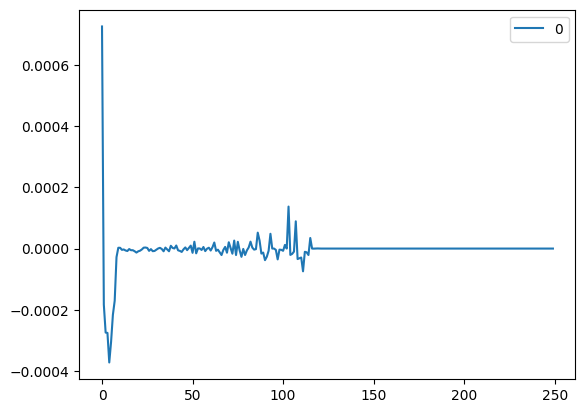

In [18]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()


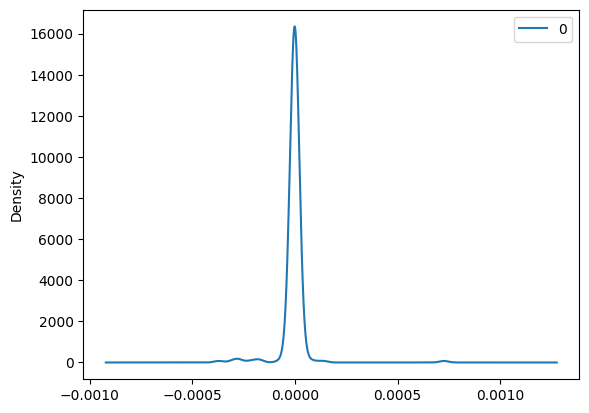

                  0
count  2.500000e+02
mean  -5.094911e-06
std    6.552756e-05
min   -3.721670e-04
25%   -3.582078e-06
50%    7.292888e-47
75%    4.991465e-18
max    7.256281e-04


In [19]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [5]:
df_seeds2 = pd.read_csv('initial_data/new_seeds_parameters.csv')
part_n2 = df_seeds2[(df_seeds2.set!='test')&(
            df_seeds2.beta==0.04)&(df_seeds2.init_inf==0.005)]

In [6]:
df2 = pd.DataFrame()
for seed2 in part_n2.file.values:
    seed_df2 = pd.read_csv(seed2)
    df2 = pd.concat([df2,seed_df2])

df2 = df2.reset_index().rename(columns={'index':'day'})

In [7]:
train_df = df2[(df2['E'] > 0)|(df2['I'] > 0)].copy()
train_df = train_df[train_df['Beta'] > 0].reset_index(drop=True)
train_df

,day,S,E,I,R,Beta
0,0,9950,0,50,0,0.000712
1,1,9596,336,62,6,0.000545
2,2,9272,618,101,9,0.000329
3,3,8964,854,157,25,0.000178
4,4,8713,1018,222,47,0.000136
...,...,...,...,...,...,...
3270,86,159,16,185,9640,0.000068
3271,87,157,17,168,9658,0.000038
3272,93,156,12,108,9724,0.000059
3273,103,155,4,47,9794,0.000137


(0.0, 1000.0)

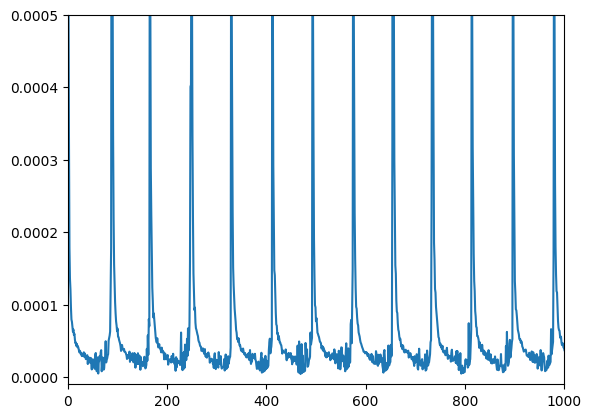

In [8]:
plt.plot(train_df.Beta);
plt.ylim(-1e-5,5e-4)
plt.xlim(0,1000)

(0.0, 1000.0)

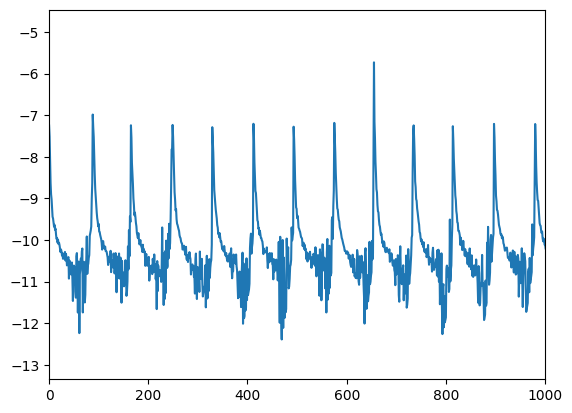

In [9]:
plt.plot(np.log(train_df.Beta));
plt.xlim(0,1000)

(array([   8.,  200., 1051., 1437.,  340.,  119.,   86.,   30.,    2.,
           2.]),
 array([-12.94352853, -12.13592913, -11.32832972, -10.52073031,
         -9.7131309 ,  -8.90553149,  -8.09793208,  -7.29033268,
         -6.48273327,  -5.67513386,  -4.86753445]),
 <BarContainer object of 10 artists>)

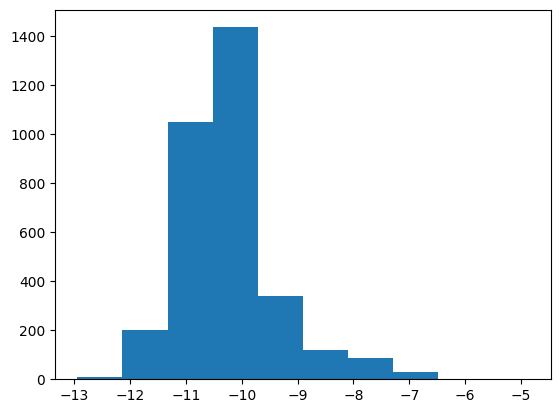

In [10]:
plt.hist(np.log(train_df.Beta))

In [11]:
test = sm.tsa.adfuller(np.log(train_df.Beta))
print('adf: ', test[0] )
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -12.744756474688003
p-value:  8.788986837115106e-24
Critical values:  {'1%': np.float64(-3.43236616722938), '5%': np.float64(-2.8624308219885193), '10%': np.float64(-2.567244203750082)}
единичных корней нет, ряд стационарен


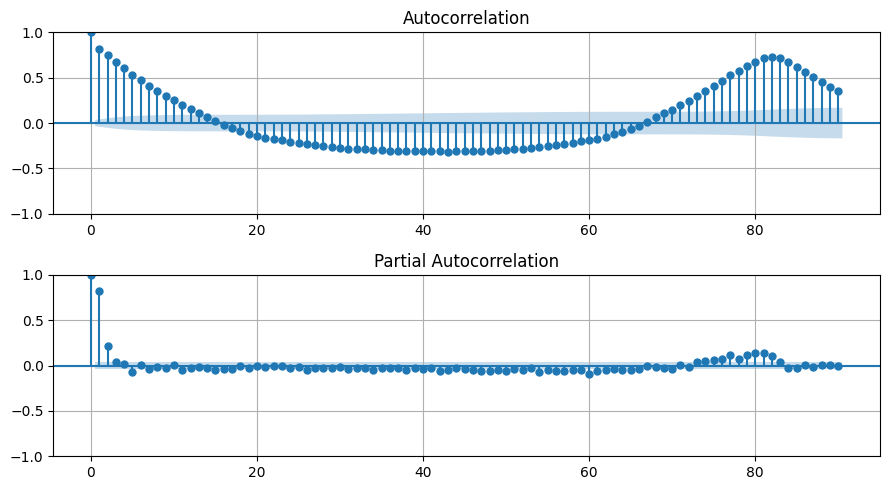

In [12]:
fig, ax = plt.subplots(2,1, figsize=(9,5))
axes = ax.flatten()

plot_acf(np.log(train_df.Beta), ax=axes[0], lags=90)
plot_pacf(np.log(train_df.Beta), ax=axes[1], lags=90)

plt.tight_layout()
axes[0].grid()
axes[1].grid()

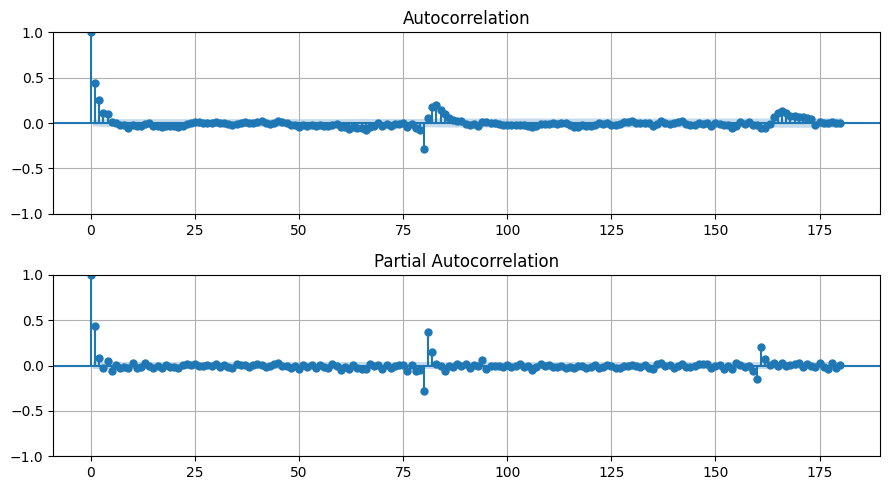

In [13]:
fig, ax = plt.subplots(2,1, figsize=(9,5))
axes = ax.flatten()

plot_acf(np.log(train_df.Beta).diff(80).dropna(), ax=axes[0], lags=180)
plot_pacf(np.log(train_df.Beta).diff(80).dropna(), ax=axes[1], lags=180)

plt.tight_layout()
axes[0].grid()
axes[1].grid()

(-0.1, 0.5)

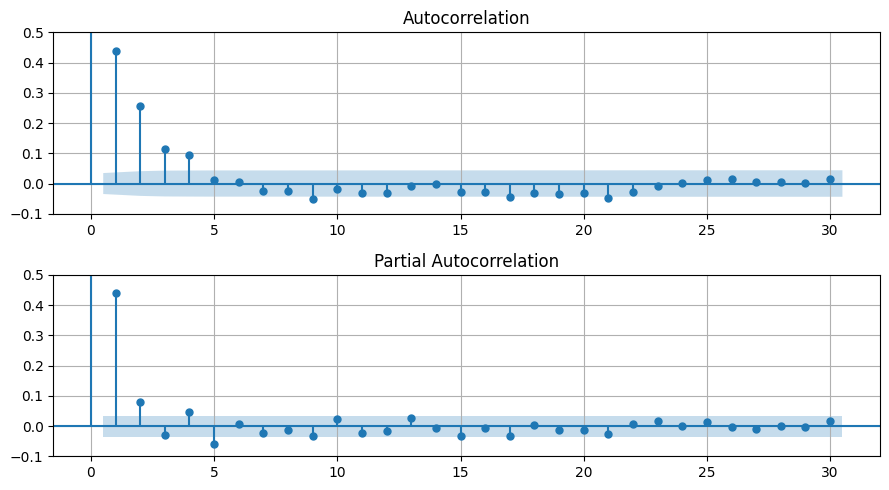

In [14]:
fig, ax = plt.subplots(2,1, figsize=(9,5))
axes = ax.flatten()

plot_acf(np.log(train_df.Beta).diff(80).dropna(), ax=axes[0], lags=30)
plot_pacf(np.log(train_df.Beta).diff(80).dropna(), ax=axes[1], lags=30)

plt.tight_layout()
axes[0].grid()
axes[1].grid()

axes[0].set_ylim(-0.1,0.5)
axes[1].set_ylim(-0.1,0.5)

In [20]:
ytrainpreed.shape

(301,)

0.34312690224218445


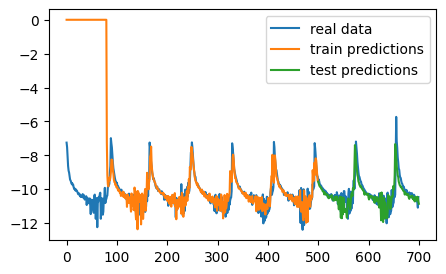

In [87]:
as_train = 500
to_pred = 200

our_data = np.log(train_df.Beta)

del_cols = ['Beta','R','S','E']
data1 = our_data[:as_train].values.reshape(-1,1)
#data2 = train_df.drop(columns=del_cols).iloc[:as_train].values
# fit model
model0 = SARIMAX(data1, #exog=data2, 
                order=(5, 0, 0), #011
                seasonal_order=(1, 1, 0, 80)
               )
model_fit0 = model0.fit(disp=False#, start_params=[0,0,0,0,0,0,0]
                     )

fig, ax = plt.subplots(1,1, figsize=(5,3))
# make prediction
#exog2 = train_df.drop(columns=del_cols).iloc[as_train:as_train+to_pred+1].values
yhat = model_fit0.predict(as_train, as_train+to_pred, #exog=exog2
                        )

ytrainpreed = model_fit0.predict(0, as_train, #exog=exog2
                        )

plt.plot(np.arange(as_train+to_pred), 
         our_data[:as_train+to_pred], label = 'real data')

plt.plot(np.arange(as_train+1), 
         ytrainpreed, label='train predictions')
plt.plot(np.arange(as_train, as_train+to_pred+1), yhat, label='test predictions')
plt.legend()

print(mean_squared_error(our_data[as_train:as_train+to_pred+1], yhat))
#plt.ylim(-1e-5,5e-4)

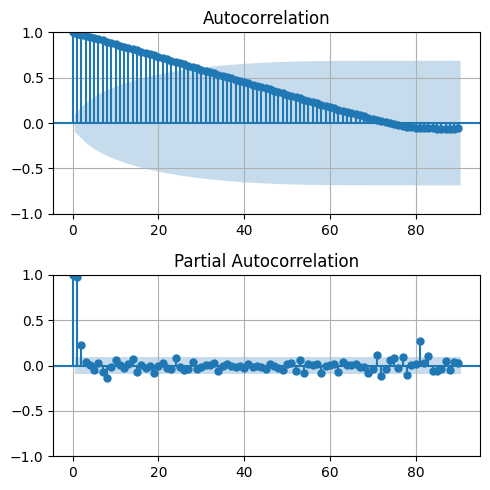

In [23]:
residuals = pd.DataFrame(model_fit0.resid)

fig, ax = plt.subplots(2,1, figsize=(5,5))
axes = ax.flatten()

plot_acf(residuals, ax=axes[0], lags=90)
plot_pacf(residuals, ax=axes[1], lags=90)

plt.tight_layout()
axes[0].grid()
axes[1].grid()

In [58]:
data1.shape

(40, 1)

In [81]:
train_df.iloc[:as_train][['I','day']].values.shape

(500, 2)

0.3519082666564856


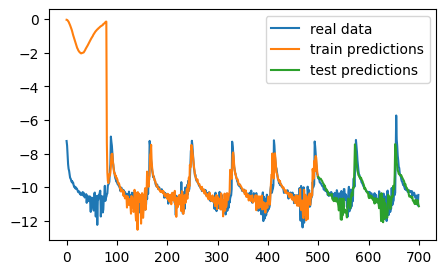

In [86]:
as_train = 500
to_pred = 200

our_data = np.log(train_df.Beta)
pop = train_df.iloc[0,:4].sum()

del_cols = ['Beta','R','S','E','day']
data1 = our_data[:as_train].values.reshape(-1,1)
data2 = train_df[['I']]/pop #.drop(columns=del_cols)

# fit model
model0 = SARIMAX(data1, exog=data2.iloc[:as_train].values, 
                order=(5, 0, 0), #011
                seasonal_order=(1, 1, 0, 80)
               )
model_fit0 = model0.fit(disp=False#, start_params=[0,0,0,0,0,0,0]
                     )

fig, ax = plt.subplots(1,1, figsize=(5,3))
# make prediction
exog2 = train_df.drop(columns=del_cols)
yhat2 = model_fit0.predict(as_train, as_train+to_pred, 
                          exog=data2.iloc[as_train:as_train+to_pred+1].values
                        )
'''
ytrainpreed = model_fit0.predict(0, as_train, 
                                 exog=data2.iloc[:as_train].values
                                )
'''
ytrainpreed = model_fit0.forecasts[0]
plt.plot(np.arange(as_train+to_pred), 
         our_data[:as_train+to_pred], label = 'real data')

plt.plot(np.arange(as_train), 
         ytrainpreed, label='train predictions')
plt.plot(np.arange(as_train, as_train+to_pred+1), yhat2, label='test predictions')
plt.legend()

print(mean_squared_error(our_data[as_train:as_train+to_pred+1], yhat2))
#plt.ylim(-1e-5,5e-4)

0.3707884564435028


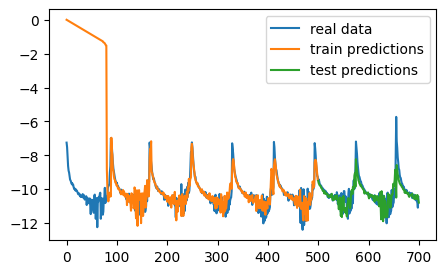

In [88]:
as_train = 500
to_pred = 200

our_data = np.log(train_df.Beta)
pop = train_df.iloc[0,:4].sum()


data1 = our_data[:as_train].values.reshape(-1,1)
data2 = train_df[['day']] #.drop(columns=del_cols)

# fit model
model0 = SARIMAX(data1, exog=data2.iloc[:as_train].values, 
                order=(5, 0, 0), #011
                seasonal_order=(1, 1, 0, 80)
               )
model_fit0 = model0.fit(disp=False#, start_params=[0,0,0,0,0,0,0]
                     )

fig, ax = plt.subplots(1,1, figsize=(5,3))
# make prediction
exog2 = train_df.drop(columns=del_cols)
yhat2 = model_fit0.predict(as_train, as_train+to_pred, 
                          exog=data2.iloc[as_train:as_train+to_pred+1].values
                        )
'''
ytrainpreed = model_fit0.predict(0, as_train, 
                                 exog=data2.iloc[:as_train].values
                                )
'''
ytrainpreed = model_fit0.forecasts[0]
plt.plot(np.arange(as_train+to_pred), 
         our_data[:as_train+to_pred], label = 'real data')

plt.plot(np.arange(as_train), 
         ytrainpreed, label='train predictions')
plt.plot(np.arange(as_train, as_train+to_pred+1), yhat2, label='test predictions')
plt.legend()

print(mean_squared_error(our_data[as_train:as_train+to_pred+1], yhat2))
#plt.ylim(-1e-5,5e-4)

C:\Users\user\anaconda3\envs\abm_seir\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.36688019470980127


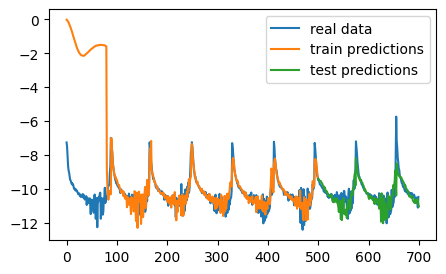

In [94]:
as_train = 500
to_pred = 200

our_data = np.log(train_df.Beta)
pop = train_df.iloc[0,:4].sum()


data1 = our_data[:as_train].values.reshape(-1,1)
data2t = train_df[['day','I']].copy() 
data2t['I'] = data2t['I']/pop
data2 = data2t[['day','I']] #.drop(columns=del_cols)

# fit model
model0 = SARIMAX(data1, exog=data2.iloc[:as_train].values.reshape(-1,2), 
                order=(5, 0, 0), #011
                seasonal_order=(1, 1, 0, 80)
               )
model_fit0 = model0.fit(disp=False#, start_params=[0,0,0,0,0,0,0]
                     )

fig, ax = plt.subplots(1,1, figsize=(5,3))
# make prediction
exog2 = train_df.drop(columns=del_cols)
yhat2 = model_fit0.predict(as_train, as_train+to_pred, 
                          exog=data2.iloc[as_train:as_train+to_pred+1].values.reshape(-1,2)
                        )

ytrainpreed = model_fit0.forecasts[0]
plt.plot(np.arange(as_train+to_pred), 
         our_data[:as_train+to_pred], label = 'real data')

plt.plot(np.arange(as_train), 
         ytrainpreed, label='train predictions')
plt.plot(np.arange(as_train, as_train+to_pred+1), yhat2, label='test predictions')
plt.legend()

print(mean_squared_error(our_data[as_train:as_train+to_pred+1], yhat2))

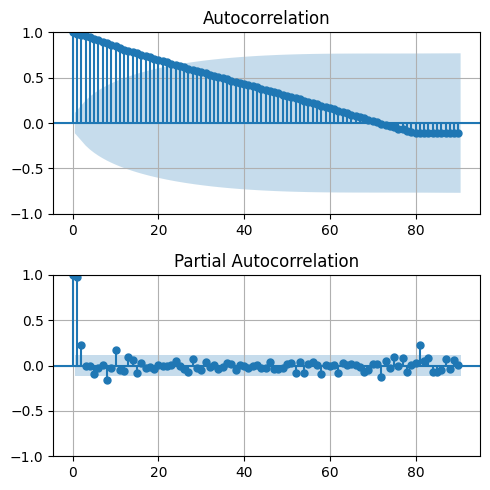

In [43]:
residuals = pd.DataFrame(model_e_fit.resid)

fig, ax = plt.subplots(2,1, figsize=(5,5))
axes = ax.flatten()

plot_acf(residuals, ax=axes[0], lags=90)
plot_pacf(residuals, ax=axes[1], lags=90)

plt.tight_layout()
axes[0].grid()
axes[1].grid()

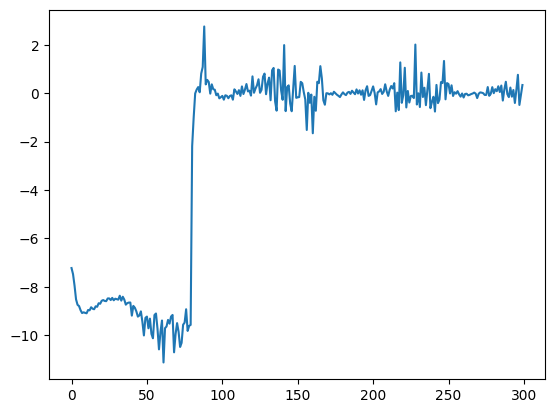

In [44]:
plt.plot(residuals)

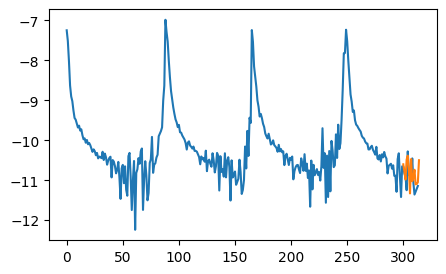

In [66]:
as_train = 300
to_pred = 14

our_data = np.log(train_df.Beta)

del_cols = ['Beta','R','E','day']
data1 = our_data[:as_train].values.reshape(-1,1)
data2 = train_df.drop(columns=del_cols).iloc[:as_train].values
# fit model
model_e = SARIMAX(data1, exog=data2, 
                order=(5, 0, 0), #011
                seasonal_order=(2, 1, 0, 80)
               )
model_e_fit = model_e.fit(disp=False#, start_params=[0,0,0,0,0,0,0]
                     )

fig, ax = plt.subplots(1,1, figsize=(5,3))
# make prediction
exog2 = train_df.drop(columns=del_cols).iloc[as_train:as_train+to_pred+1].values
yhat = model_e_fit.predict(as_train, as_train+to_pred, exog=exog2
                        )


plt.plot(np.arange(as_train+to_pred), 
         our_data[:as_train+to_pred])
plt.plot(np.arange(as_train, as_train+to_pred+1), yhat)
#plt.ylim(-1e-5,5e-4)

In [ ]:
as_train = 300
to_pred = 14

our_data = np.log(train_df.Beta)

del_cols = ['Beta','R']
data1 = our_data[:as_train].values.reshape(-1,1)
data2 = train_df.drop(columns=del_cols).iloc[:as_train].values
# fit model
model_e = SARIMAX(data1, exog=data2, 
                order=(5, 0, 0), #011
                seasonal_order=(2, 1, 0, 80)
               )
model_e_fit = model_e.fit(disp=False#, start_params=[0,0,0,0,0,0,0]
                     )

fig, ax = plt.subplots(1,1, figsize=(5,3))
# make prediction
exog2 = train_df.drop(columns=del_cols).iloc[as_train:as_train+to_pred+1].values
yhat = model_e_fit.predict(as_train, as_train+to_pred, exog=exog2
                        )


plt.plot(np.arange(as_train+to_pred), 
         our_data[:as_train+to_pred])
plt.plot(np.arange(as_train, as_train+to_pred+1), yhat)
#plt.ylim(-1e-5,5e-4)

In [ ]:
as_train = 200
to_pred = 14

our_data = np.log(train_df.Beta)

del_cols = ['Beta','R','S','E']
data1 = our_data[:as_train].values.reshape(-1,1)
#data2 = train_df.drop(columns=del_cols).iloc[:as_train].values
# fit model
model0 = SARIMAX(data1, #exog=data2, 
                order=(7, 1, 4), #011
                seasonal_order=(1, 1, 1, 80)
               )
model_fit0 = model0.fit(disp=False#, start_params=[0,0,0,0,0,0,0]
                     )

fig, ax = plt.subplots(1,1, figsize=(5,3))
# make prediction
#exog2 = train_df.drop(columns=del_cols).iloc[as_train:as_train+to_pred+1].values
yhat = model_fit0.predict(as_train, as_train+to_pred, #exog=exog2
                        )


plt.plot(np.arange(as_train+to_pred), 
         our_data[:as_train+to_pred])
plt.plot(np.arange(as_train, as_train+to_pred+1), yhat)
#plt.ylim(-1e-5,5e-4)

In [ ]:
residuals = pd.DataFrame(model_fit0.resid)

fig, ax = plt.subplots(2,1, figsize=(5,5))
axes = ax.flatten()

plot_acf(residuals, ax=axes[0])
plot_pacf(residuals, ax=axes[1])

plt.tight_layout()
axes[0].grid()
axes[1].grid()

In [39]:
as_train = 300
to_pred = 14

our_data = np.log(train_df.Beta)

del_cols = ['Beta','R','S','E']
data1 = our_data[:as_train].values.reshape(-1,1)
#data2 = train_df.drop(columns=del_cols).iloc[:as_train].values
# fit model
model = SARIMAX(data1, #exog=data2, 
                order=(1, 1, 1), #011
                seasonal_order=(1, 1, 1, 80)
               )
model_fit = model.fit(disp=False#, start_params=[0,0,0,0,0,0,0]
                     )

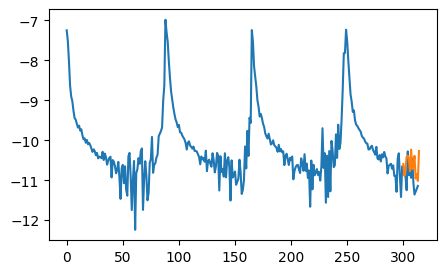

In [40]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
# make prediction
#exog2 = train_df.drop(columns=del_cols).iloc[as_train:as_train+to_pred+1].values
yhat = model_fit.predict(as_train, as_train+to_pred, #exog=exog2
                        )


plt.plot(np.arange(as_train+to_pred), 
         our_data[:as_train+to_pred])
plt.plot(np.arange(as_train, as_train+to_pred+1), yhat)
#plt.ylim(-1e-5,5e-4)

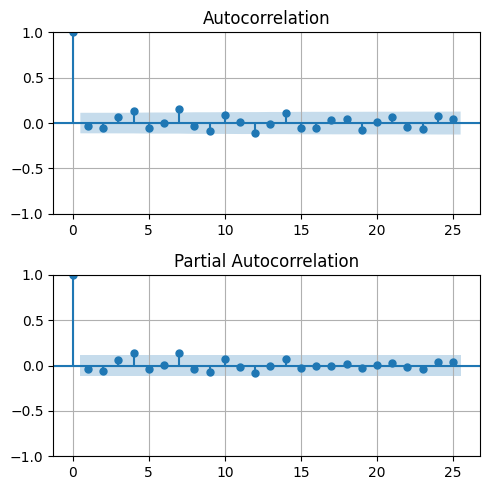

In [41]:
residuals = pd.DataFrame(model_fit.resid)

fig, ax = plt.subplots(2,1, figsize=(5,5))
axes = ax.flatten()

plot_acf(residuals, ax=axes[0])
plot_pacf(residuals, ax=axes[1])

plt.tight_layout()
axes[0].grid()
axes[1].grid()

In [248]:
q = train_df[train_df.Beta > 0.0004].index.diff()
q[q>1].values.mean()

np.float64(80.71794871794872)

In [249]:
q[q>1]

Index([87.0, 75.0, 81.0, 79.0, 82.0, 80.0, 81.0, 79.0, 77.0, 78.0, 82.0, 82.0,
       77.0, 80.0, 74.0, 78.0, 77.0, 86.0, 82.0, 86.0, 81.0, 81.0, 82.0, 81.0,
       84.0, 84.0, 83.0, 81.0, 76.0, 84.0, 80.0, 80.0, 81.0, 81.0, 84.0, 80.0,
       79.0, 81.0, 82.0],
      dtype='float64')

In [ ]:
#as_train = 700
to_pred = 14

del_cols = ['Beta','R','S','E']
data1 = train_df.Beta.iloc[:as_train].values.reshape(-1,1)
data2 = train_df.drop(columns=del_cols).iloc[:as_train].values
# fit model
model = SARIMAX(data1, #exog=data2, 
                order=(0, 1, 0), #011
                seasonal_order=(1, 1, 1, 80)
               )
model_fit = model.fit(disp=False#, start_params=[0,0,0,0,0,0,0]
                     )

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
# make prediction
exog2 = train_df.drop(columns=del_cols).iloc[as_train:as_train+to_pred+1].values
yhat = model_fit.predict(as_train, as_train+to_pred, #exog=exog2
                        )


plt.plot(np.arange(as_train+to_pred), 
         train_df.Beta.iloc[:as_train+to_pred])
plt.plot(np.arange(as_train, as_train+to_pred+1), yhat)
plt.ylim(-1e-5,5e-4)

<Axes: >

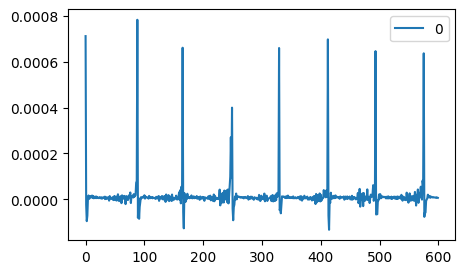

In [228]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(ax=ax)

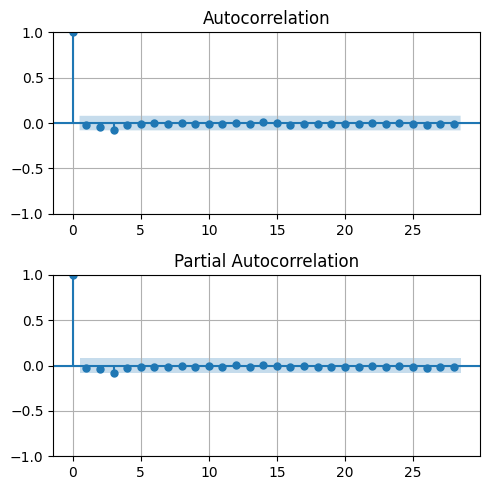

In [229]:
fig, ax = plt.subplots(2,1, figsize=(5,5))
axes = ax.flatten()

plot_acf(residuals, ax=axes[0])
plot_pacf(residuals, ax=axes[1])

plt.tight_layout()
axes[0].grid()
axes[1].grid()

In [17]:
as_train = 50
to_pred = 14

del_cols = ['Beta','R','S','E']
data1 = train_df.Beta.iloc[:as_train].values.reshape(-1,1)
data2 = train_df.drop(columns=del_cols).iloc[:as_train].values
# fit model
model = SARIMAX(data1, exog=data2, order=(1, 0, 0), 
                seasonal_order=(1, 0, 0, 100))
model_fit = model.fit(disp=False#, start_params=[0,0,0,0,0,0,0]
                     )

D:\Programs\Anaconda\envs\abm_seir\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(-1e-05, 0.0005)

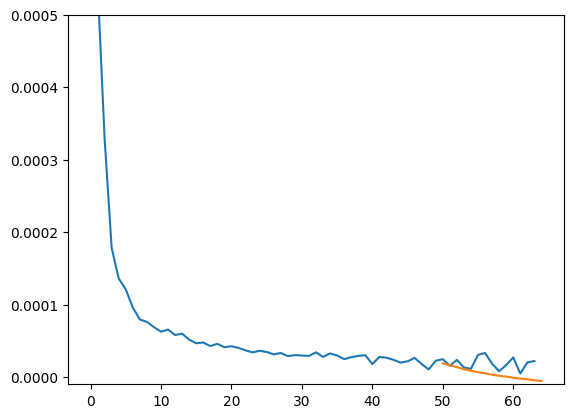

In [19]:
# make prediction
exog2 = train_df.drop(columns=del_cols).iloc[as_train:as_train+to_pred+1].values
yhat = model_fit.predict(as_train, as_train+to_pred, exog=exog2)


plt.plot(np.arange(as_train+to_pred), 
         train_df.Beta.iloc[:as_train+to_pred])
plt.plot(np.arange(as_train, as_train+to_pred+1), yhat)
plt.ylim(-1e-5,5e-4)

In [31]:
train_df['Beta'].diff(1)

0            NaN
1      -0.000167
2      -0.000216
3      -0.000151
4      -0.000042
          ...   
9836    0.000041
9837   -0.000030
9843    0.000021
9853    0.000078
9857    0.000034
Name: Beta, Length: 3275, dtype: float64

In [29]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(train_df['Beta'])

ADF Statistic: -25.502285921440663
p-value: 0.0
Stationary


## sw

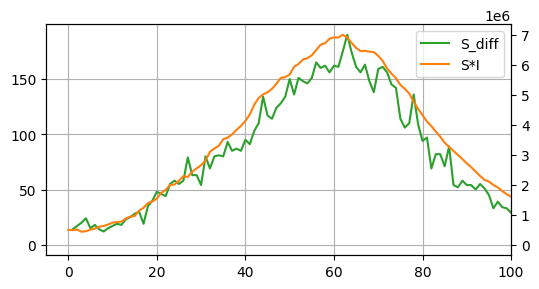

In [95]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
ax_b = ax.twinx()

l1 = ax.plot(-seed_df1.S.diff(), color='tab:green', label='S_diff')
l2 = ax_b.plot(seed_df1.S * seed_df1.I, color='tab:orange', label='S*I')

plt.xlim(-5, 100)

lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.grid()

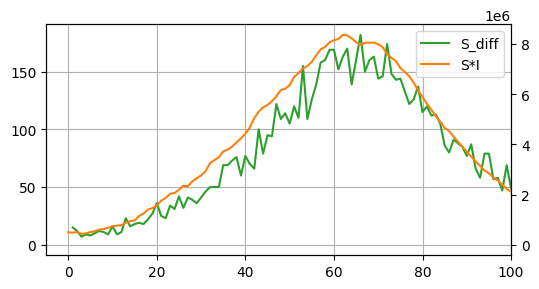

In [96]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
ax_b = ax.twinx()

l1 = ax.plot(-seed_df2.S.diff(), color='tab:green', label='S_diff')
l2 = ax_b.plot(seed_df2.S * seed_df1.I, color='tab:orange', label='S*I')

plt.xlim(-5, 100)


lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.grid()

## ba

In [49]:
seed_df1.head()

,S,E,I,R,Beta
0,9950,0,50,0,0.000103
1,9899,51,45,5,0.000112
2,9849,96,48,7,0.000078
3,9812,124,52,12,0.000104
4,9759,167,60,14,0.000084


In [50]:
seed_df2.head()

,S,E,I,R,Beta
0,9950,0,50,0,0.000726
1,9589,345,65,1,0.000542
2,9251,637,106,6,0.000355
3,8903,919,161,17,0.000254
4,8539,1183,247,31,0.000173


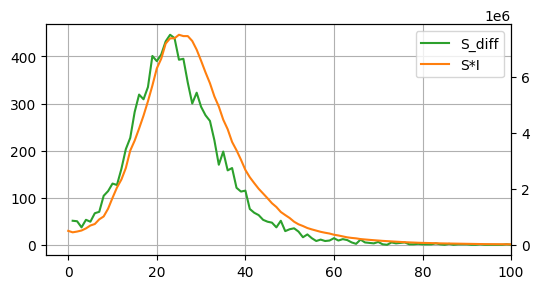

In [56]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
ax_b = ax.twinx()

l1 = ax.plot(-seed_df1.S.diff(), color='tab:green', label='S_diff')
l2 = ax_b.plot(seed_df1.S * seed_df1.I, color='tab:orange', label='S*I')

plt.xlim(-5, 100)

lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.grid()

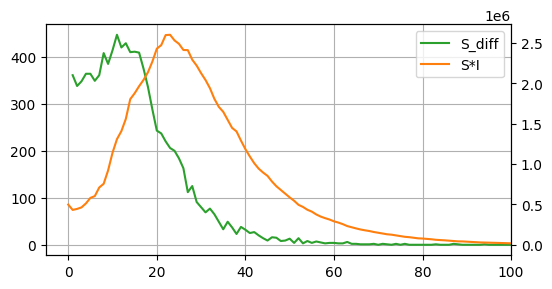

In [57]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
ax_b = ax.twinx()

l1 = ax.plot(-seed_df2.S.diff(), color='tab:green', label='S_diff')
l2 = ax_b.plot(seed_df2.S * seed_df1.I, color='tab:orange', label='S*I')

plt.xlim(-5, 100)


lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.grid()